## Band Excitation data procesing using pycroscopy
#### Suhas Somnath, Chris R. Smith, Stephen Jesse
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
2/10/2017


## cKPFM analysis
#### Sabine Neumayer
University College Dublin<br> 
7/4/2017

![notebook_rules.png](notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

## Configure the notebook

In [1]:
# Make sure needed packages are installed and up-to-date
import sys
!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py
!{sys.executable} -m pip install -U --no-deps sidpy bglib

Solving environment: ...working... done

# All requested packages already installed.



In [2]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import sys
import os
import math

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipywidgets as widgets

from IPython.display import display, HTML

# Finally, BGlib itself
sys.path.append('..')

from BGlib import be as belib
import pyUSID as usid
import sidpy

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
# set up notebook to show plots within the notebook
%matplotlib notebook

## Set some basic parameters for computation
This notebook performs some functional fitting whose duration can be substantially decreased by using more memory and CPU cores. We have provided default values below but you may choose to change them if necessary.

In [4]:
max_mem         = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
max_cores       = None    # Number of logical cores to use in fitting.  None uses all but 2 available cores.

## Make the data pycroscopy compatible
Converting the raw data into a pycroscopy compatible hierarchical data format (HDF or .h5) file gives you access to the fast fitting algorithms and powerful analysis functions within pycroscopy

#### H5 files:
* are like smart containers that can store matrices with data, folders to organize these datasets, images, metadata like experimental parameters, links or shortcuts to datasets, etc.
* are readily compatible with high-performance computing facilities
* scale very efficiently from few kilobytes to several terabytes
* can be read and modified using any language including Python, Matlab, C/C++, Java, Fortran, Igor Pro, etc.

#### You can load either of the following:
* Any .mat or .txt parameter file from the original experiment
* A .h5 file generated from the raw data using pycroscopy - skips translation

You can select desired file type by choosing the second option in the pull down menu on the bottom right of the file window

In [6]:
input_file_path = r'C:/Users/yla/Google Drive/PD time files/User Work/SimonFraser_ZuoGuangYe/sample2/BEcKPFM_2um_0012.h5'

(data_dir, filename) = os.path.split(input_file_path)

if input_file_path.endswith('.h5'):
    # No translation here
    h5_path = input_file_path
    force = False # Set this to true to force patching of the datafile.
    tl = belib.translators.LabViewH5Patcher()
    tl.translate(h5_path, force_patch=force)
else:
    # Set the data to be translated
    data_path = input_file_path

    (junk, base_name) = os.path.split(data_dir)

    # Check if the data is in the new or old format.  Initialize the correct translator for the format.
    if base_name == 'newdataformat':
        (junk, base_name) = os.path.split(junk)
        translator = belib.translators.BEPSndfTranslator(max_mem_mb=max_mem)
    else:
        translator = belib.translators.BEodfTranslator(max_mem_mb=max_mem)
    if base_name.endswith('_d'):
        base_name = base_name[:-2]
    # Translate the data
    h5_path = translator.translate(data_path, show_plots=True, save_plots=False)

h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

File is already Pycroscopy ready.
Working on:
C:/Users/yla/Google Drive/PD time files/User Work/SimonFraser_ZuoGuangYe/sample2/BEcKPFM_2um_0012.h5


C:\Users\yla\Anaconda3\lib\site-packages\sidpy\sid\translator.py:42: FutureWarning: Consider using sidpy.Reader instead of sidpy.Translator if possible and contribute your reader to ScopeReaders
  warn('Consider using sidpy.Reader instead of sidpy.Translator if '


##### Inspect the contents of this h5 data file
The file contents are stored in a tree structure, just like files on a conventional computer.
The data is stored as a 2D matrix (position, spectroscopic value) regardless of the dimensionality of the data. Thus, the positions will be arranged as row0-col0, row0-col1.... row0-colN, row1-col0.... and the data for each position is stored as it was chronologically collected  

The main dataset is always accompanied by four ancillary datasets that explain the position and spectroscopic value of any given element in the dataset.

In [7]:
print('Datasets and datagroups within the file:\n------------------------------------')
usid.hdf_utils.print_tree(h5_file)
 
print('\nThe main dataset:\n------------------------------------')
print(h5_main)
print('\nThe ancillary datasets:\n------------------------------------')
print(h5_file['/Measurement_000/Channel_000/Position_Indices'])
print(h5_file['/Measurement_000/Channel_000/Position_Values'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Indices'])
print(h5_file['/Measurement_000/Channel_000/Spectroscopic_Values'])

print('\nMetadata or attributes in a datagroup\n------------------------------------')
for key in h5_file['/Measurement_000'].attrs:
    print('{} : {}'.format(key, h5_file['/Measurement_000'].attrs[key]))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Raw_Data-SHO_Fit_001
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
      ├ completed_fit_positions
      ├ completed_guess_positions
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
  ├ Channel_001
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Sp

## Get some basic parameters from the H5 file
This information will be vital for futher analysis and visualization of the data

In [8]:
h5_pos_inds = h5_main.h5_pos_inds
pos_dims = h5_main.pos_dim_sizes
pos_labels = h5_main.pos_dim_labels
print(pos_labels, pos_dims)

parm_dict = h5_file['/Measurement_000'].attrs
is_ckpfm = True

num_write_steps = parm_dict['VS_num_DC_write_steps']
num_read_steps = parm_dict['VS_num_read_steps']
num_fields = 2

['X', 'Y'] [10, 10]


## Visualize the raw data
Use the sliders below to visualize spatial maps (2D only for now), and spectrograms.
For simplicity, all the spectroscopic dimensions such as frequency, excitation bias, cycle, field, etc. have been collapsed to a single slider.

No position datasets found as attributes of /Measurement_000/Channel_000/Spectroscopic_Values


<IPython.core.display.Javascript object>


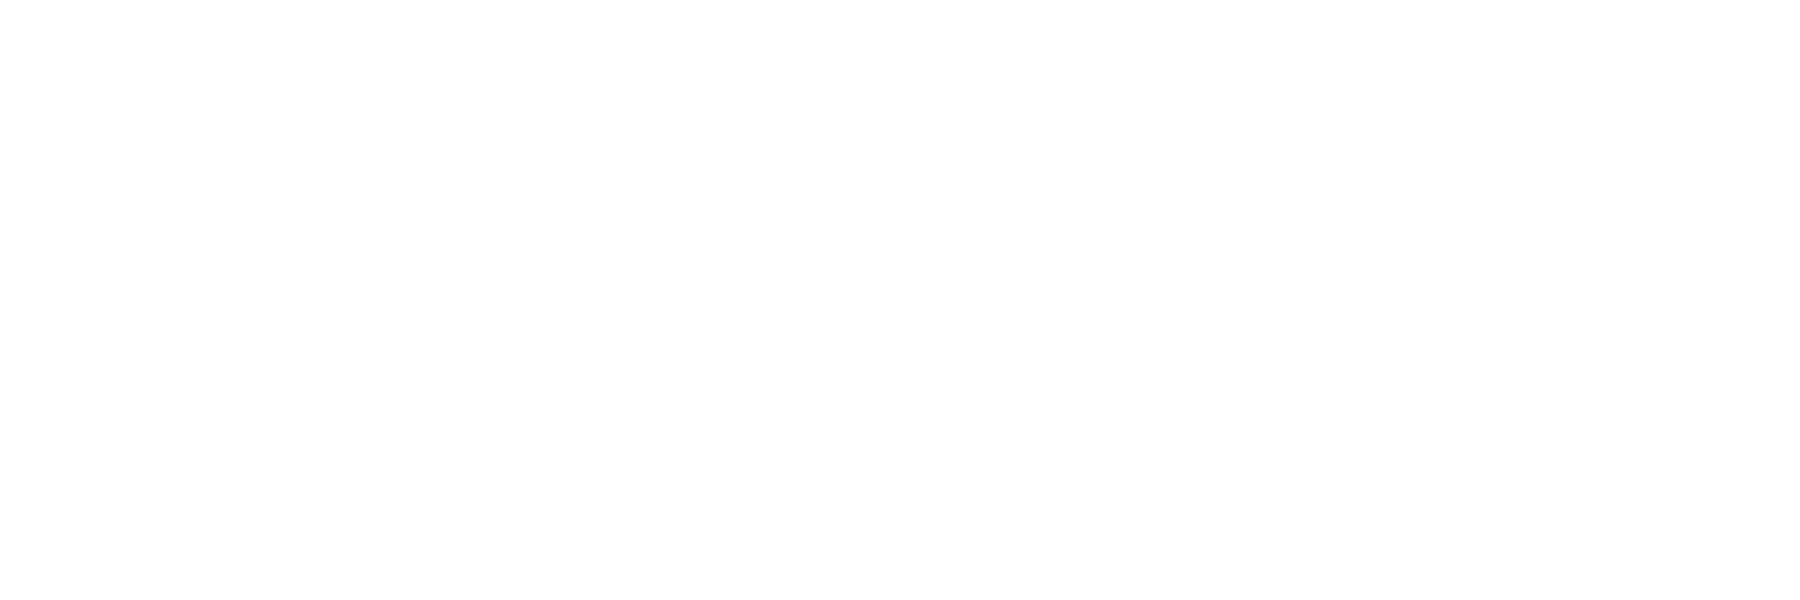

interactive(children=(IntSlider(value=0, description='Step', max=54560), Output()), _dom_classes=('widget-inte…

In [9]:
fig = belib.viz.be_viz_utils.jupyter_visualize_be_spectrograms(h5_main)

In [10]:
h5_main

<HDF5 dataset "Raw_Data": shape (100, 54560), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	quantity (a.u.) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 10 
	Y - size: 10 
Spectroscopic Dimensions: 
	Frequency - size: 124 
	Field - size: 2 
	write_bias - size: 20 
	read_bias - size: 11
Data Type:
	complex64

## Fit the Band Excitation (BE) spectra
Fit each of the acquired spectra to a simple harmonic oscillator (SHO) model to extract the following information regarding the response:
* Oscillation amplitude
* Phase
* Resonance frequency
* Quality factor

By default, the cell below will take any previous result instead of re-computing the SHO fit

In [11]:
sho_fit_points = 5  # The number of data points at each step to use when fitting
sho_override = False  # Force recompute if True
results_to_new_file = False

h5_sho_targ_grp = None
if results_to_new_file:
    h5_sho_file_path = os.path.join(folder_path, 
                                h5_raw_file_name.replace('.h5', '_sho_fit.h5'))
    print('\n\nSHO Fits will be written to:\n' + h5_sho_file_path + '\n\n')
    f_open_mode = 'w'
    if os.path.exists(h5_sho_file_path):
        f_open_mode = 'r+'
    h5_sho_file = h5py.File(h5_sho_file_path, mode=f_open_mode)
    h5_sho_targ_grp = h5_sho_file
    
sho_fitter = belib.analysis.BESHOfitter(h5_main, cores=max_cores, verbose=False, h5_target_group=h5_sho_targ_grp)
sho_fitter.set_up_guess(guess_func=belib.analysis.be_sho_fitter.SHOGuessFunc.complex_gaussian,
                        num_points=sho_fit_points)
h5_sho_guess = sho_fitter.do_guess(override=sho_override)
sho_fitter.set_up_fit()
h5_sho_fit = sho_fitter.do_fit(override=sho_override)
h5_sho_grp = h5_sho_fit.parent

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file
Group: <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_000" (3 members)> had neither the status HDF5 dataset or the legacy attribute: "last_pixel".

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (7 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SHO_Fit_001" (7 members)>]
Returned previously computed results at /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001

Note: SHO_Fit has already been performed with the same parameters before. These results will 

# cKPFM data analysis

- Specify the output file path where the figures should be saved to.
- Set high_voltage_amplf to 10 if a high voltage amplifier was used, otherwise set to 1

In [12]:
# Specify output file path, default is the same directory as the data
output_file_path = data_dir

# If HV amplifier was used set high_voltage_amplf to 10, else to 1
high_voltage_amplf = 1


## Remove phase offset

If removing the instrumental phase offset is not desired, set phase_offset = 0

In [13]:
Nd_mat = h5_sho_fit.get_n_dim_form()
print('Nd_mat shape = ', Nd_mat.shape)

phase_offset = Nd_mat[0, 0, 1, 0, 0]['Phase [rad]']

print('Phase offset [rad] = ', phase_offset)

Nd_mat[:,:,:,:,:]['Phase [rad]'] = Nd_mat[:,:,:,:,:]['Phase [rad]'] - phase_offset


Nd_mat shape =  (10, 10, 2, 20, 11)
Phase offset [rad] =  -0.3490023


## Display cKPFM data
The figure shows:

- Read and write voltage steps with the selected step marked as a red dot
- Response map at read and write voltage steps selected with sliders
- Real component of the response at selected read and write steps and x/y coordinates <b> -> select option</b>
- Response at each write step (x-axis) after each write pulse (color coded)

The 'Save figure' button saves the displayed figure in the above specified output file path as tiff, png and eps file. Alternatively, figures can be copy pasted into other programs like Powerpoint or Word.

#### Select display option by setting 'option = 1' or 'option = 2' in the second line of the code
- Option 1: display response curves from the maximum write step to the minimum write step
- Option 2: display response curves from all write voltages

In [14]:
def plot_line_family(axis, x_vec, line_family, line_names=None, label_prefix='', label_suffix='',
                     y_offset=0, show_cbar=False, **kwargs):
    """
    Plots a family of lines with a sequence of colors

    Parameters
    ----------
    axis : matplotlib.axes.Axes object
        Axis to plot the curve
    x_vec : array-like
        Values to plot against
    line_family : 2D numpy array
        family of curves arranged as [curve_index, features]
    line_names : array-like
        array of string or numbers that represent the identity of each curve in the family
    label_prefix : string / unicode
        prefix for the legend (before the index of the curve)
    label_suffix : string / unicode
        suffix for the legend (after the index of the curve)
    y_offset : (optional) number
        quantity by which the lines are offset from each other vertically (useful for spectra)
    show_cbar : (optional) bool
        Whether or not to show a colorbar (instead of a legend)

    """
    
    x_vec = np.array(x_vec)
    #assert x_vec.ndim == 1, 'x_vec must be a 1D array'
    if not isinstance(line_family, list):
        line_family = np.array(line_family)
   
    assert line_family.ndim == 2, 'line_family must be a 2D array'
    #    assert x_vec.shape[1] == line_family.shape[1], \
    #        'The size of the 2nd dimension of line_family must match with of x_vec, but line fam has shape {} whereas xvec has shape {}'.format(line_family.shape, x_vec.shape)
    num_lines = line_family.shape[0]


    if line_names is None:
        # label_prefix = 'Line '
        line_names = [str(line_ind) for line_ind in range(num_lines)]

    line_names = ['{} {} {}'.format(label_prefix, cur_name, label_suffix) for cur_name in line_names]
    
    print("Line family shape is {}".format(line_family.shape))
    
    for line_ind in range(num_lines):
        colors = plt.cm.get_cmap('jet', line_family.shape[-1])
        axis.plot(x_vec, line_family[line_ind] + line_ind * y_offset,
                  color = colors(line_ind),
                  )

    if show_cbar:
        # put back the cmap parameter:
        kwargs.update({'cmap': cmap})
        _ = cbar_for_line_plot(axis, num_lines, **kwargs)


In [15]:
global option, save_figure 
# Option 1: only show curves from maximum to minimum write voltage
# Option 2: Show all curves from the whole write voltage waveform
option = 1 
save_figure = False # Save the figure after being generated if True

h5_sho_spec_inds = h5_sho_fit.h5_spec_inds
h5_sho_spec_vals = h5_sho_fit.h5_spec_vals

sho_spec_labels = h5_sho_fit.spec_dim_labels
pos_labels = h5_sho_fit.pos_dim_labels

num_fields = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('Field')]
num_write_steps = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('write_bias')]
num_read_steps = h5_sho_fit.spec_dim_sizes[h5_sho_fit.spec_dim_labels.index('read_bias')]

# It turns out that the read voltage index starts from 1 instead of 0
# Also the VDC indices are NOT repeating. They are just rising monotonically
write_volt_index = sho_spec_labels.index('write_bias')
read_volt_index = sho_spec_labels.index('read_bias')
h5_sho_spec_inds[read_volt_index, :] -= np.min(h5_sho_spec_inds[read_volt_index, :])
h5_sho_spec_inds[write_volt_index, :] = np.tile(np.repeat(np.arange(num_write_steps), num_fields), num_read_steps)

# Get the bias matrix:
bias_mat, _ = usid.hdf_utils.reshape_to_n_dims(h5_sho_spec_vals, h5_spec=h5_sho_spec_inds)
bias_vec_r_all = bias_mat[read_volt_index]*high_voltage_amplf
bias_vec_w_all = bias_mat[write_volt_index]*high_voltage_amplf
bias_vec_w = bias_vec_w_all.reshape(h5_sho_fit.spec_dim_sizes)[1, :, 1]
bias_vec_r = bias_vec_r_all.reshape(h5_sho_fit.spec_dim_sizes)[1, :, :]

# Option 1: only show curves from maximum to minimum write voltage:
if option == 1:
    write_step_start = np.argmax(bias_vec_w)
    write_step_end = np.argmin(bias_vec_w)

# ption 2: show all curves from the whole write voltage waveform
if option == 2:
    write_step_start = 0
    write_step_end = num_write_steps-1

bias_vec_r_display = np.transpose(bias_vec_r[write_step_start:write_step_end+1,:])

print('These are the labels', sho_spec_labels)

nd_labels = h5_sho_fit.n_dim_labels

num_read_steps = Nd_mat.shape[nd_labels.index('read_bias')]
num_write_steps = Nd_mat.shape[nd_labels.index('write_bias')]
num_row = Nd_mat.shape[nd_labels.index('Y')]
num_col = Nd_mat.shape[nd_labels.index('X')]

# Indices of initial data points to plot
row = 0
col = 0
field = 1
dc_step_read = 0
dc_step_write = 0

# Select color scale range for map here
cmin = -0.0001
cmax = 0.0001

# Get the read and write data to plot
resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000

resp_mat_r = Nd_mat[:,:,1,dc_step_write,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,dc_step_write,dc_step_read]['Phase [rad]'])*1000

resp_vec_r = np.squeeze(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)


def make_figure(resp_mat_r, resp_vec_r, resp_vec_w, dc_step_read, dc_step_write, col, row):
    global save_figure
    plt.clf();
    fig = plt.figure(figsize=(13, 9))
    fig.set_facecolor('white')
    
    ax_bias_w = plt.subplot2grid((20, 2), (0, 0), colspan=1, rowspan=3)
    ax_bias_r = plt.subplot2grid((20, 2), (5, 0), colspan=1, rowspan=3)
    ax_loop_w = plt.subplot2grid((20, 2), (0, 1), colspan=1, rowspan=7)
    ax_loop_r = plt.subplot2grid((20, 2), (9, 1), colspan=1, rowspan=8)
    ax_colorbar = plt.subplot2grid((20, 2), (19, 1), colspan=1, rowspan=1)
    ax_map = plt.subplot2grid((20, 2), (10, 0), colspan=1, rowspan=11)
    
    
    
    ax_bias_w.set_xlabel('Step', fontsize = 12)
    ax_bias_w.set_ylabel('Write voltage [V]', fontsize = 12)
    ax_bias_r.set_xlabel('Step', fontsize = 12)
    ax_bias_r.set_ylabel('Read voltage [V]', fontsize = 12)
    ax_loop_w.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_loop_w.set_xlabel('Write voltage [V]', fontsize = 12)
    ax_loop_r.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_loop_r.set_xlabel('Read voltage [V]', fontsize = 12)

    # Title saying read and write voltages
    fig.suptitle('Read voltage = '+str(bias_vec_r[1,dc_step_read])+' V, Write voltage = ' +str(bias_vec_w[dc_step_write])+' V'
                ', x = '+str(col)+', y = '+str(row), fontsize = 14);
    
    co_b = ax_map.imshow(resp_mat_r, cmap = sidpy.plot_utils.cmap_jet_white_center(), origin='upper', 
                         interpolation='none');
    cb = fig.colorbar(co_b)
    
    #Graph of DC write voltage
    ax_bias_w.plot(bias_vec_w,'b.');
    ax_bias_w.plot(dc_step_write,bias_vec_w[dc_step_write],'r.');
    ax_bias_w.set_ylim([np.min(bias_vec_w)-0.5, np.max(bias_vec_w)+0.5])
    
    #Graph of DC read voltage
    ax_bias_r.plot(np.transpose(bias_vec_r[1]),'b.');
    ax_bias_r.plot(dc_step_read,np.transpose(bias_vec_r[1,dc_step_read]),'r.');
    ax_bias_r.set_ylim([np.min(bias_vec_r)-0.5, np.max(bias_vec_r)+0.5])
        
    #Graph of response loop (amplitude * cos(phase)) vs write voltage at selected x, y and read step
    ax_loop_w.plot(bias_vec_w, resp_vec_w,'.-');
    
    #Response loops (amplitude * cos(phase)) of all write voltage steps (color coded) vs read voltage at selected x, y
    plot_line_family(ax_loop_r, bias_vec_r_display[:, :], 
                                   resp_vec_r, line_names='None',
                                   label_prefix='Line', label_suffix='')
    
    if option == 1:
        colorbar_mat = np.column_stack((range(write_step_start,write_step_end+1),range(write_step_start,write_step_end+1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        plt.sca(ax_colorbar)
        plt.xticks([0,write_step_end-write_step_start],[bias_vec_w[write_step_start],bias_vec_w[write_step_end]])
        ax_colorbar.set_xlabel('Write voltage [V]', fontsize = 12)
                
    if option == 2:
        colorbar_mat = np.column_stack((range(0,num_write_steps-1),range(0,num_write_steps-1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        ax_colorbar.set_xlabel('Write voltage step', fontsize = 12)
        
    
    if save_figure == True:
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.png', format='png')
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.eps', format='eps')
        fig.savefig(output_file_path+'\cb_cKPFM_Vr'+str(dc_step_read)+'_Vw'+str(dc_step_write)+'_x='+str(col)+'_y='+str(row)+'.tif', format='tiff')
        save_figure = False

        
def update_sho_plots(dc_step_read, dc_step_write, col, row, **kwargs):
    resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000
    resp_vec_w = Nd_mat[row,col,field,:,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[row,col,field,:,dc_step_read]['Phase [rad]'])*1000
    resp_mat_r = Nd_mat[:,:,1,dc_step_write,dc_step_read]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,dc_step_write,dc_step_read]['Phase [rad]'])*1000
    resp_vec_r = (Nd_mat[row,col,field,write_step_start:write_step_end+1,:]['Amplitude [V]'] 
                           * np.cos(Nd_mat[row,col,field,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)

    make_figure(resp_mat_r, resp_vec_r, resp_vec_w, dc_step_read, dc_step_write, col, row)
    
    
def on_save_button_clicked(b):
    global save_figure 
    save_figure = True
    dc_step_read =  dc_step_read_slider.value
    dc_step_write = dc_step_write_slider.value
    col = x_slider.value
    row = y_slider.value
    
    update_sho_plots(dc_step_read,dc_step_write, col, row)
    

slider_dict = dict()   

dc_step_read_slider = widgets.IntSlider(min = 0, max = num_read_steps-1, step = 1,value = 4,
                                        description = 'Read step',continuous_update = False);
dc_step_write_slider = widgets.IntSlider(min = 0, max = num_write_steps-1, step = 1,value = 0,
                                         description = 'Write step', continuous_update = False);
x_slider = widgets.IntSlider(min = 0, max = num_col-1,step = 1,value = 0,
                             description='x',continuous_update = False);
y_slider = widgets.IntSlider(min = 0,max = num_row-1,step = 1,value = 0,
                             description = 'y',continuous_update = False);

widgets.interact(update_sho_plots,dc_step_read=dc_step_read_slider,dc_step_write=dc_step_write_slider, col = x_slider, row = y_slider, **slider_dict); 

button = widgets.Button(description = 'Save figure')
display(button)
button.on_click(on_save_button_clicked)


No position datasets found as attributes of /Measurement_000/Channel_000/Raw_Data-SHO_Fit_001/Spectroscopic_Values
These are the labels ['Field', 'write_bias', 'read_bias']


interactive(children=(IntSlider(value=4, continuous_update=False, description='Read step', max=10), IntSlider(…

Button(description='Save figure', style=ButtonStyle())

## Display averaged cKPFM data

Figures show response at each write step (x-axis) after each write pulse (color coded) averaged over the whole map (left) and averaged over the area selected with x- and y-range sliders (right).

#### Select display option by setting 'option = 1' or 'option = 2' in the first line of the code
- Option 1: display response curves from the maximum write step to the minimum write step
- Option 2: display response curves from all write voltages

In [16]:
option = 1

# Option 1: only show curves from maximum to minimum write voltage:
if option == 1:
    write_step_start = np.argmax(bias_vec_w)
    write_step_end = np.argmin(bias_vec_w)

# Option 2: show all curves from the whole write voltage waveform
if option == 2:
    write_step_start = 0
    write_step_end = num_write_steps-1

    
bias_vec_r_display = np.transpose(bias_vec_r[write_step_start:write_step_end+1,:])

num_display_steps = bias_vec_r_display.shape[1]


global save_figure_vsr

save_figure_vsr = False


resp_mat_vsr = np.squeeze(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,1,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)

# Calculate response at 0 V read voltage averaged over all pixels
resp_vsr_mean1 = np.nanmean(resp_mat_vsr,axis = 0)
resp_vsr_std1 = np.nanstd(resp_mat_vsr,axis = 0)
resp_vsr_mean = np.nanmean(resp_vsr_mean1,axis = 0)
resp_vsr_std = np.nanstd(resp_vsr_std1,axis = 0)


def make_figure_respvsr(resp_vsr_mean_range, resp_vsr_std_range, x_range, y_range):
    global save_figure_vsr
    
    fig_vsr = plt.figure(figsize=(12,5))  
    fig_vsr.clf()
    fig_vsr.set_facecolor('white')
    ax_plot = plt.subplot2grid((5, 2), (0, 0), colspan=1, rowspan=4)
    ax_plot_range = plt.subplot2grid((5, 2), (0, 1), colspan=1, rowspan=4)
    ax_colorbar = plt.subplot2grid((5, 2), (4, 0), colspan=1, rowspan=1)
    ax_colorbar2 = plt.subplot2grid((5, 2), (4, 1), colspan=1, rowspan=1)

    plot_line_family(ax_plot, bias_vec_r_display[:, :], 
                                   resp_vsr_mean[:, :], line_names='None',label_prefix='Line', 
                                   label_suffix='', cmap=plt.cm.jet)
    plot_line_family(ax_plot_range, bias_vec_r_display[:, :], 
                                   resp_vsr_mean_range[:, :], line_names='None',
                                   label_prefix='Line', label_suffix='', cmap=plt.cm.jet)
         
    ax_plot.set_xlabel('Read voltage [V]', fontsize = 12)
    ax_plot.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_plot.set_title('Averaged over whole map', fontsize = 12)
    
    ax_plot_range.set_xlabel('Read voltage [V]', fontsize = 12)
    ax_plot_range.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_plot_range.set_title('Averaged x = '+str(x_range[0])+' - '+str(x_range[1])
                            +', y = '+str(y_range[0])+' - '+str(y_range[1]), fontsize = 12)
    if option == 1:
        colorbar_mat = np.column_stack((range(write_step_start,write_step_end+1),range(write_step_start,write_step_end+1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        plt.sca(ax_colorbar)
        plt.xticks([0,write_step_end-write_step_start],[bias_vec_w[write_step_start],bias_vec_w[write_step_end]])
        ax_colorbar.set_xlabel('Write voltage [V]', fontsize = 12)
        
        ax_colorbar2.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar2.set_yticklabels('')
        ax_colorbar2.tick_params(axis = 'y', left = 'off', right = 'off')
        plt.sca(ax_colorbar2)
        plt.xticks([0,write_step_end-write_step_start],[bias_vec_w[write_step_start],bias_vec_w[write_step_end]])
        ax_colorbar2.set_xlabel('Write voltage [V]', fontsize = 12)

        
    
    if option == 2:
        colorbar_mat = np.column_stack((range(0,num_write_steps-1),range(0,num_write_steps-1)))
        ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar.set_yticklabels('')
        ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')
        ax_colorbar.set_xlabel('Write voltage step', fontsize = 12)
        
        ax_colorbar2.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none')
        ax_colorbar2.set_yticklabels('')
        ax_colorbar2.tick_params(axis = 'y', left = 'off', right = 'off')
        ax_colorbar2.set_xlabel('Write voltage step', fontsize = 12)
        
     
        
    fig_vsr.tight_layout();
   
    if save_figure_vsr == True:
        fig_vsr.savefig(output_file_path+'\cbColor_Response_vsReadVoltage_x'+str(x_range)+'_y'+str(y_range)+'.png', format='png')
        fig_vsr.savefig(output_file_path+'\cbColor_Response_vsReadVoltage_x'+str(x_range)+'_y'+str(y_range)+'.eps', format='eps')
        fig_vsr.savefig(output_file_path+'\cbColor_Response_vsReadVoltage_x'+str(x_range)+'_y'+str(y_range)+'.tif', format='tiff')
        save_figure_vsr = False
        
        
            

def update_xyrange(x_range, y_range):

# Calculate response averaged over selected pixels
    
    resp_mat_vsr_range = np.squeeze(Nd_mat[y_range[0]:y_range[1], x_range[0]:x_range[1],1,write_step_start:write_step_end+1,:]['Amplitude [V]']
                                    *np.cos(Nd_mat[y_range[0]:y_range[1], x_range[0]:x_range[1],1,write_step_start:write_step_end+1,:]['Phase [rad]'])*1000)
    
    resp_vsr_mean1_range = np.nanmean(resp_mat_vsr_range,axis = 0)
    resp_vsr_std1_range = np.nanstd(resp_mat_vsr_range,axis = 0)
    resp_vsr_mean_range = np.nanmean(resp_vsr_mean1_range,axis = 0)
    resp_vsr_std_range = np.nanstd(resp_vsr_std1_range,axis = 0)

    make_figure_respvsr(resp_vsr_mean_range, resp_vsr_std_range, x_range, y_range)
                                        
                                          
x_range = widgets.IntRangeSlider(min = 0,max = num_col-1,step = 1,value = 0,
                             description = 'x-range',continuous_update = False)

y_range = widgets.IntRangeSlider(min = 0,max = num_col-1,step = 1,value = 0,
                             description = 'y-range',continuous_update = False)

widgets.interact(update_xyrange,x_range = x_range, y_range = y_range);



def on_save_button_clicked_vsr(b):
    global save_figure_vsr 
    save_figure_vsr = True
  
    update_xyrange(x_range.value, y_range.value)

button_vsr = widgets.Button(description = 'Save figure')
display(button_vsr)
button_vsr.on_click(on_save_button_clicked_vsr)




interactive(children=(IntRangeSlider(value=(2, 6), continuous_update=False, description='x-range', max=9), Int…

Button(description='Save figure', style=ButtonStyle())

## Export response after all write steps for all pixels

Response data (\= amplitude * cos(phase)) is exported into separate tab delimited text files for each read voltage (see file names). The columns in the text file represent write voltage steps, the rows represent individual pixels. 

In [17]:
#Export response of all write steps (columns) for all pixels (rows) to one delimited text file for each read step

for dc_step_read in range(0,num_read_steps-1):
    resp_mat = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,1,:,dc_step_read]['Phase [rad]'])*1000)

    resp_vec = np.reshape(resp_mat, (num_row*num_col, num_write_steps))
    np.savetxt(os.path.join(output_file_path,'Response_at_Vread_'+str(bias_vec_r[0,dc_step_read])+'V.txt'),resp_vec, fmt='%f', delimiter='\t')

np.savetxt(os.path.join(output_file_path,'Read_voltage_vec.txt'), np.squeeze(bias_vec_r[0,:]), fmt='%f', delimiter='\t')
np.savetxt(os.path.join(output_file_path,'Write_voltage_vec.txt'), np.squeeze(bias_vec_w[:]), fmt='%f', delimiter='\t')

## Display averaged response at 0 V read voltage

The left figure shows response at 0 V read voltage averaged over the whole grid, the right figure shows response at 0 V read voltage averaged over the x- and y- range specified with sliders.

In [18]:
# Plot response at 0 V read voltage averaged over all pixels
global save_figure_0V

save_figure_0V = False
dc_step_read = np.argwhere(np.isclose(bias_vec_r[0,:], 0)).squeeze()

resp_mat_0Vr = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,1,:,dc_step_read]['Phase [rad]'])*1000)

# Calculate response at 0 V read voltage averaged over all pixels
resp_0V_mean1 = np.nanmean(resp_mat_0Vr,axis = 0)
resp_0V_std1 = np.nanstd(resp_mat_0Vr,axis = 0)
resp_0V_mean = np.nanmean(resp_0V_mean1,axis = 0)
resp_0V_std = np.nanstd(resp_0V_std1,axis = 0)


def make_figure_resp0V(resp_0V_mean_range, resp_0V_std_range, x_range, y_range):
    global save_figure_0V
    
    fig_r0V = plt.figure(figsize=(10,4))  
    fig_r0V.clf()
    fig_r0V.set_facecolor('white')
    ax_plot = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax_plot_range = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    
    ax_plot.plot(bias_vec_w[:], resp_0V_mean
                 , '.-')
    ax_plot.errorbar(bias_vec_w[:], resp_0V_mean, yerr = resp_0V_std, fmt = '.-')
    
    ax_plot.set_xlabel('Write voltage [V]', fontsize = 12)
    ax_plot.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_plot.set_title('Averaged over whole map', fontsize = 12)
    
    ax_plot_range.errorbar(bias_vec_w[:], resp_0V_mean_range, yerr = resp_0V_std_range, fmt = '.-')
    ax_plot_range.set_xlabel('Write voltage [V]', fontsize = 12)
    ax_plot_range.set_ylabel('Response [a.u.]', fontsize = 12)
    ax_plot_range.set_title('Averaged from x = '+str(x_range[0])+'-'+str(x_range[1])
                            +', y = '+str(y_range[0])+'-'+str(y_range[1]), fontsize = 12)
    
    fig_r0V.tight_layout();
    fig_r0V.suptitle('Spatially averaged response at read voltage = 0 V', y = 1.05, x=0.55, fontsize = 12)
    
    #save_figure_0V = True   
    if save_figure_0V == True:
        fig_r0V.savefig(output_file_path+'\Response_0V_x'+str(x_range)+'_y'+str(y_range)+'.png', format='png')
        fig_r0V.savefig(output_file_path+'\Response_0V_x'+str(x_range)+'_y'+str(y_range)+'.eps', format='eps')
        fig_r0V.savefig(output_file_path+'\Response_0V_x'+str(x_range)+'_y'+str(y_range)+'.tif', format='tiff')
        save_figure_0V = False
        
        
        

def update_xyrange(x_range, y_range):

# Calculate response at 0 V read voltage averaged over selected pixels
#     a=Nd_mat[x_range[0]:x_range[1], y_range[0]:y_range[1],1,:,dc_step_read]['Amplitude [V]']
    
    resp_mat_0Vr_range = np.squeeze(Nd_mat[y_range[0]:y_range[1], x_range[0]:x_range[1],1,:,dc_step_read]['Amplitude [V]']
                                    *np.cos(Nd_mat[y_range[0]:y_range[1], x_range[0]:x_range[1],1,:,dc_step_read]['Phase [rad]'])*1000)
    
    resp_0V_mean1_range = np.nanmean(resp_mat_0Vr_range,axis = 0)
    resp_0V_std1_range = np.nanstd(resp_mat_0Vr_range,axis = 0)
    resp_0V_mean_range = np.nanmean(resp_0V_mean1_range,axis = 0)
    resp_0V_std_range = np.nanstd(resp_0V_std1_range,axis = 0)
    
    print(resp_0V_mean_range, resp_0V_std_range, x_range, y_range)
    
    make_figure_resp0V(resp_0V_mean_range, resp_0V_std_range, x_range, y_range)
                                          
                                          
x_range = widgets.IntRangeSlider(min = 0,max = num_col-1,step = 0.1,value = 0,
                             description = 'x-range',continuous_update = False)

y_range = widgets.IntRangeSlider(min = 0,max = num_col-1,step = 0.1,value = 0,
                             description = 'y-range',continuous_update = False)

widgets.interact(update_xyrange,x_range = x_range, y_range = y_range);



def on_save_button_clicked_0V(b):
    global save_figure_0V 
    save_figure_0V = True

   
    update_xyrange(x_range.value, y_range.value)

button_0V = widgets.Button(description = 'Save figure')
display(button_0V)
button_0V.on_click(on_save_button_clicked_0V)

interactive(children=(IntRangeSlider(value=(2, 6), continuous_update=False, description='x-range', max=9, step…

Button(description='Save figure', style=ButtonStyle())

## Display response, amplitude and phase data at 0 V read voltage for a single pixel

Select the pixel of interest below by setting x_select and y_select to the desired coordinates.

<IPython.core.display.Javascript object>


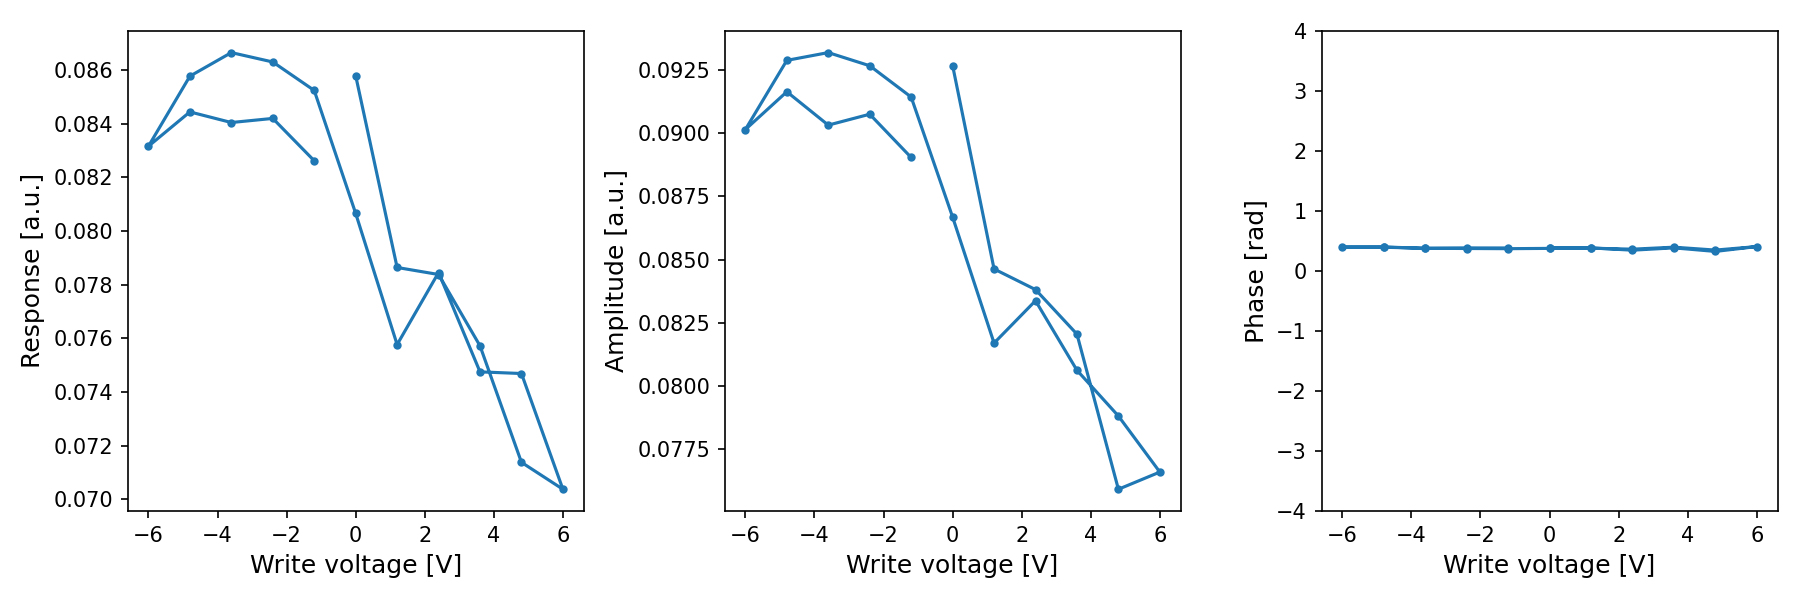

In [19]:
x_select = 3
y_select = 2

resp_mat_0Vr = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,1,:,dc_step_read]['Phase [rad]'])*1000)
amp_mat_0Vr = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Amplitude [V]'])*1000
phase_mat_0Vr = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Phase [rad]'])


fig_r0V = plt.figure(figsize=(12,4))  
fig_r0V.clf()
fig_r0V.set_facecolor('white')
ax_resp = plt.subplot2grid((1, 3), (0, 0), colspan=1, rowspan=1)
ax_amp = plt.subplot2grid((1, 3), (0, 1), colspan=1, rowspan=1)
ax_phase = plt.subplot2grid((1, 3), (0, 2), colspan=1, rowspan=1)

ax_resp.plot(bias_vec_w[:], resp_mat_0Vr[y_select, x_select, :],'.-')
ax_resp.set_xlabel('Write voltage [V]', fontsize = 12)
ax_resp.set_ylabel('Response [a.u.]', fontsize = 12)

ax_amp.plot(bias_vec_w[:], amp_mat_0Vr[y_select, x_select, :],'.-')
ax_amp.set_xlabel('Write voltage [V]', fontsize = 12)
ax_amp.set_ylabel('Amplitude [a.u.]', fontsize = 12)

ax_phase.plot(bias_vec_w[:], phase_mat_0Vr[y_select, x_select, :],'.-')
ax_phase.set_xlabel('Write voltage [V]', fontsize = 12)
ax_phase.set_ylabel('Phase [rad]', fontsize = 12)
ax_phase.set_ylim([-4, 4])

fig_r0V.tight_layout()

## Display on-field loops for all read steps

The figure shows on-field response vs. write voltage for all read voltages (color coded) averaged over the whole map.

In [20]:
resp_mat_IF = np.squeeze(Nd_mat[:,:,0,:,:]['Amplitude [V]'] 
                          * np.cos(Nd_mat[:,:,0,:,:]['Phase [rad]'])*1000)

# Calculate response at 0 V read voltage averaged over all pixels
resp_IF_mean1 = np.nanmean(resp_mat_IF,axis = 0)
resp_IF_std1 = np.nanstd(resp_mat_IF,axis = 0)
resp_IF_mean = np.nanmean(resp_IF_mean1,axis = 0)
resp_IF_std = np.nanstd(resp_IF_std1,axis = 0)

bias_vec_w_graph = np.matlib.repmat(bias_vec_w,num_read_steps, 1)
# print(resp_IF_mean.shape, resp_IF_std.shape, bias_vec_w_graph.shape)

fig_IF = plt.figure(figsize=(6,6))  
fig_IF.clf()
fig_IF.set_facecolor('white')
ax_plot = plt.subplot2grid((15, 5), (0, 0), colspan=5, rowspan=12)
ax_colorbar = plt.subplot2grid((15, 5), (14, 0), colspan=5, rowspan=1)

px.plot_utils.plot_line_family(ax_plot, np.transpose(bias_vec_w_graph), np.transpose(resp_IF_mean), line_names='None',label_prefix='Line', label_suffix='', cmap=plt.cm.jet)
# ax_plot.plot(bias_vec_w[:], resp_IF_mean, '.-')
# ax_plot.errorbar(bias_vec_w[:], resp_IF_mean, yerr = resp_IF_std, fmt = '.-')
colorbar_mat = np.column_stack((range(0,num_read_steps),range(0,num_read_steps)))
ax_colorbar.imshow(np.transpose(colorbar_mat[:,:]), cmap=plt.cm.jet, origin='lower', interpolation='none', aspect = 0.25)
ax_colorbar.set_yticklabels('')


ax_colorbar.tick_params(axis = 'y', left = 'off', right = 'off')


# ax_colorbar.set_xlabel('Read step')
    

ax_plot.set_xlabel('Write voltage [V]', fontsize = 12)
ax_plot.set_ylabel('In field response [a.u.]', fontsize = 12)
ax_plot.set_title('Averaged over whole map', fontsize = 12)

labels = list(range(num_read_steps))

for i in range(0, num_read_steps-0, 1):
    labels[i] = str(bias_vec_r[0,i])

ax_colorbar.set_xticks(np.arange(num_read_steps))
ax_colorbar.set_xticklabels(labels, fontsize = 10)

ax_colorbar.set_xlabel('Read voltage [V]', fontsize = 12)
# fig_IF.tight_layout();

def on_save_button4_clicked(b):
    
    fig_IF.savefig(output_file_path+'\IFresponse.png', format='png')
    fig_IF.savefig(output_file_path+'\IFresponse.eps', format='eps')
    fig_IF.savefig(output_file_path+'\IFresponse.tif', format='tiff')

    
    
button4 = widgets.Button(description = 'Save figure')
display(button4)
button4.on_click(on_save_button4_clicked)

AttributeError: module 'numpy' has no attribute 'matlib'

## Calculate the jCPD

The junction contact potential difference (jCPD) is extracted for each dc write voltage step by linear fitting of the response vs. read bias and calculating the x-intercept.

If only a certain (linear) regime of the cKPFM curves should be fitted, set v_read_start_index and v_read_end_index to the first and last index of the data that should be considered for the fit.

In [22]:
#Calculate x intercept -> jCPD

v_read_start_index = 0
v_read_end_index = num_read_steps-1

print('v_read_start_index = ', v_read_start_index, ', v_read_end_index = ', v_read_end_index)
# resp_mat_r_all_all = Nd_mat[:,:,1,:,:]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,:,:]['Phase [rad]'])*1000
resp_mat_r_all = Nd_mat[:,:,1,:,v_read_start_index : v_read_end_index+1]['Amplitude [V]'] * np.cos(Nd_mat[:,:,1,:,v_read_start_index : v_read_end_index+1]['Phase [rad]'])*1000


# print(num_read_steps)
# print(resp_mat_r_all.shape)
# print('resp_mat_r_all', resp_mat_r_all[0,0,0,:])
# print('resp_mat_r_all_all', resp_mat_r_all_all[0,0,0,:])

fit_slope = np.zeros((num_col, num_row, num_write_steps))
fit_yintercept = np.zeros((num_col, num_row, num_write_steps))
jCPD_mat = np.zeros((num_col, num_row, num_write_steps))
   
print(bias_vec_r[1,v_read_start_index : v_read_end_index+1])
# print(bias_vec_r[1,:])

for row in range(num_row):
    for col in range(num_col):
        for vw in range(0,num_write_steps-1):
            fit_coeff = np.polyfit(bias_vec_r[1,v_read_start_index : v_read_end_index+1], resp_mat_r_all[col, row, vw,:],1)
            fit_slope[col, row, vw] = fit_coeff[0]
            fit_yintercept[col, row, vw] = fit_coeff[1]
            jCPD_mat[col, row, vw] = -fit_coeff[1]/ fit_coeff[0]
            

# fit_y = fit_coeff[0] * bias_vec_r[1,:] + fit_coeff[1]

# row = 1
# col = 1
# vw = 10         
# print(fit_slope[col, row, vw])
# print(fit_yintercept[col, row, vw])
# print(jCPD_mat[col ,row, vw])


# plt.figure(1)
# plt.plot(bias_vec_r[1,:],resp_mat_r_all[col, row, vw,:],'.-')
# plt.plot(bias_vec_r[1,:],fit_y)
# print(fit_coeff[0],fit_coeff[1],jCPD_mat[col, row, vw])
#Filter outliers from jCPD matrix, (-> improve code)
# for r in range(1, num_row):
#     for c in range(1, num_col):
#         for s in range(1, num_write_steps):
#             if jCPD_mat[r-1, c-1, s-1] > 20 or jCPD_mat[r-1, c-1, s-1] < -20:
# #                 jCPD_mat[r-1, c-1, s-1] = np.nan
#                 jCPD_mat[r-1, c-1, s-1] = 0



v_read_start_index =  0 , v_read_end_index =  10
[-1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8  1. ]


## Display jCPD data
Figure shows

- The jCPD map for the write voltage step selected with the slider
- Graphs of jCPD cross sections along the selected x- and y- axes for the selected write voltage step

In [24]:
global save_figure

save_figure = False

#Color scale minimum and maximum
cmin = -0.2
cmax = 0.02
  
def make_jCPD_figure(dc_step_write, x_select, y_select):    
    global save_figure 

    fig2 = plt.figure(figsize=(14,8))  
    fig2.set_facecolor('white')    
    ax_jCPD_xcross_section = plt.subplot2grid((10, 10), (0, 7), colspan=4, rowspan=3)
    plt.title('jCPD cross section at x ='+str(x_select), fontsize = 12)
    
    ax_jCPD_ycross_section = plt.subplot2grid((10, 10), (4, 7), colspan=4, rowspan=3)
    plt.title('jCPD cross section at y ='+str(y_select), fontsize = 12)
    
    ax_jCPD_plot = plt.subplot2grid((10, 10), (0, 0), colspan=6, rowspan=7)
    plt.title('jCPD [V] at write voltage = '+str(bias_vec_w[dc_step_write])+' V', fontsize = 12)
    

    
    ax_jCPD_xcross_section.plot(range(num_col),jCPD_mat[:,x_select,dc_step_write],'.-')
    ax_jCPD_xcross_section.set_xlabel('Pixel #', fontsize = 12)
    ax_jCPD_xcross_section.set_ylabel('jCPD [V]', fontsize = 12)
  
    ax_jCPD_ycross_section.plot(range(num_row),jCPD_mat[y_select,:,dc_step_write],'.-')
    ax_jCPD_ycross_section.set_xlabel('Pixel #', fontsize = 12)
    ax_jCPD_ycross_section.set_ylabel('jCPD [V]', fontsize = 12)
    
#     co_b2 = ax_jCPD_plot.imshow(jCPD_mat[:,:,dc_step_write], 
#                                 cmap=px.plot_utils.cmap_jet_white_center(), 
#                                 origin='lower', interpolation='none', clim=(cmin, cmax));
    co_b2 = ax_jCPD_plot.imshow(jCPD_mat[:,:,dc_step_write], 
                                cmap=usid.plot_utils.cmap_jet_white_center(), 
                                origin='upper', interpolation='none');
    cb2 = fig2.colorbar(co_b2)
   
    
    if save_figure == True:
        fig2.savefig(output_file_path+'jCPD_map_WriteStep'+str(dc_step_write)+'y'+str(row)+'.png', format='png')
        fig2.savefig(output_file_path+'jCPD_map_WriteStep'+str(dc_step_write)+'y'+str(row)+'.eps', format='eps')
        save_figure = False;

    

slider_dict = dict()      
dc_step_write_slider = widgets.IntSlider(min = 0, max = num_write_steps-1, step = 1,value = 0,description='Write Step');
x_slider = widgets.IntSlider(min = 0, max = num_col, step = 1, value = 0, description = 'x')
y_slider = widgets.IntSlider(min = 0, max = num_row, step = 1, value = 0, description = 'y')

widgets.interact(make_jCPD_figure, dc_step_write = dc_step_write_slider, x_select = x_slider, y_select = y_slider, **slider_dict); 


def on_save_button2_clicked(b):
    global save_figure
    save_figure = True 
    
    dc_step_write = dc_step_write_slider.value
    x_select = x_slider.value
    y_select = y_slider.value
     
    make_jCPD_figure(dc_step_write, x_select, y_select)
    
    
button2 = widgets.Button(description = 'Save figure')
display(button2)
button2.on_click(on_save_button2_clicked)

interactive(children=(IntSlider(value=0, description='Write Step', max=19), IntSlider(value=0, description='x'…

Button(description='Save figure', style=ButtonStyle())

## Display jCPD and fitting parameters

Figure shows maps of
- jCPD
- slope
- y-intercept

for the write voltage step selected with slider.

In [26]:
global save_figure

save_figure = False
   
cmin = -3
cmax = 3
  
def make_fitting_figure(dc_step_write):    
    global save_figure 
    fig3 = plt.figure(figsize=(10,3))  
    fig3.set_facecolor('white')    
    ax_jCPD_plot = plt.subplot(131)
    ax_slope_plot = plt.subplot(132)
    ax_yintercept_plot = plt.subplot(133)
    ax_slope_plot.set_title('Slope [a.u.]', fontsize = 12)
    
    im3 = ax_jCPD_plot.imshow(jCPD_mat[:,:,dc_step_write], 
                                cmap=usid.plot_utils.cmap_jet_white_center(), 
                                origin='upper', interpolation='none');
    
#     im3 = ax_jCPD_plot.imshow(jCPD_mat[:,:,dc_step_write], 
#                                 cmap=px.plot_utils.cmap_jet_white_center(), 
#                                 origin='upper', interpolation='none', clim=(cmin, cmax)); 
    
    fig3.colorbar(im3, ax = ax_jCPD_plot)
    ax_jCPD_plot.set_title('jCPD [V]', fontsize = 12)
    
    im = ax_slope_plot.imshow(fit_slope[:,:,dc_step_write], 
                                cmap=usid.plot_utils.cmap_jet_white_center(), 
                                origin='upper', interpolation='none');
       
    fig3.colorbar(im, ax = ax_slope_plot)
    
    im2 = ax_yintercept_plot.imshow(fit_yintercept[:,:,dc_step_write], 
                                cmap=usid.plot_utils.cmap_jet_white_center(), 
                                origin='upper', interpolation='none');
    ax_yintercept_plot.set_title('y-intercept [a.u.]', fontsize = 12)
    
    fig3.colorbar(im2, ax = ax_yintercept_plot)
    
    #fig3.suptitle('Write voltage = '+str(bias_vec_w[dc_step_write])+' V', fontsize = 14, y = 1.06)
    
    fig3.suptitle('Write voltage = '+str(bias_vec_w[dc_step_write])+' V', fontsize = 14)
    
    
#     fig3.add_subplot(132).text(2,11,'Write voltage = '+str(bias_vec_w[dc_step_write])+' V', fontsize = 14, orientation='vertical')
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    if save_figure == True:
        fig3.savefig(output_file_path+'\jCPD_map_WriteStep'+str(dc_step_write)+'.png', format='png')
        fig3.savefig(output_file_path+'\jCPD_map_WriteStep'+str(dc_step_write)+'.eps', format='eps')
        fig3.savefig(output_file_path+'\jCPD_map_WriteStep'+str(dc_step_write)+'.tif', format='tif')
        save_figure = False;

    
slider_dict = dict()      
dc_step_write_slider = widgets.IntSlider(min = 0, max = num_write_steps-1, step = 1, value = 0, description='Write Step');

widgets.interact(make_fitting_figure, dc_step_write = dc_step_write_slider, **slider_dict); 


def on_save_button3_clicked(b):
    global save_figure
    save_figure = True 
    
    dc_step_write = dc_step_write_slider.value
#     x_select = x_slider.value
#     y_select = y_slider.value
     
    make_fitting_figure(dc_step_write)
    
    
button3 = widgets.Button(description = 'Save figure')
display(button3)
button3.on_click(on_save_button3_clicked)

interactive(children=(IntSlider(value=0, description='Write Step', max=19), Output()), _dom_classes=('widget-i…

Button(description='Save figure', style=ButtonStyle())

## jCPD plots

- Left graph depicts the jCPD averaged over all pixels as a function of write voltage
- Specify a pixel that jCPD data should be displayed from in graph on the right by setting x_select and y_select.

<IPython.core.display.Javascript object>


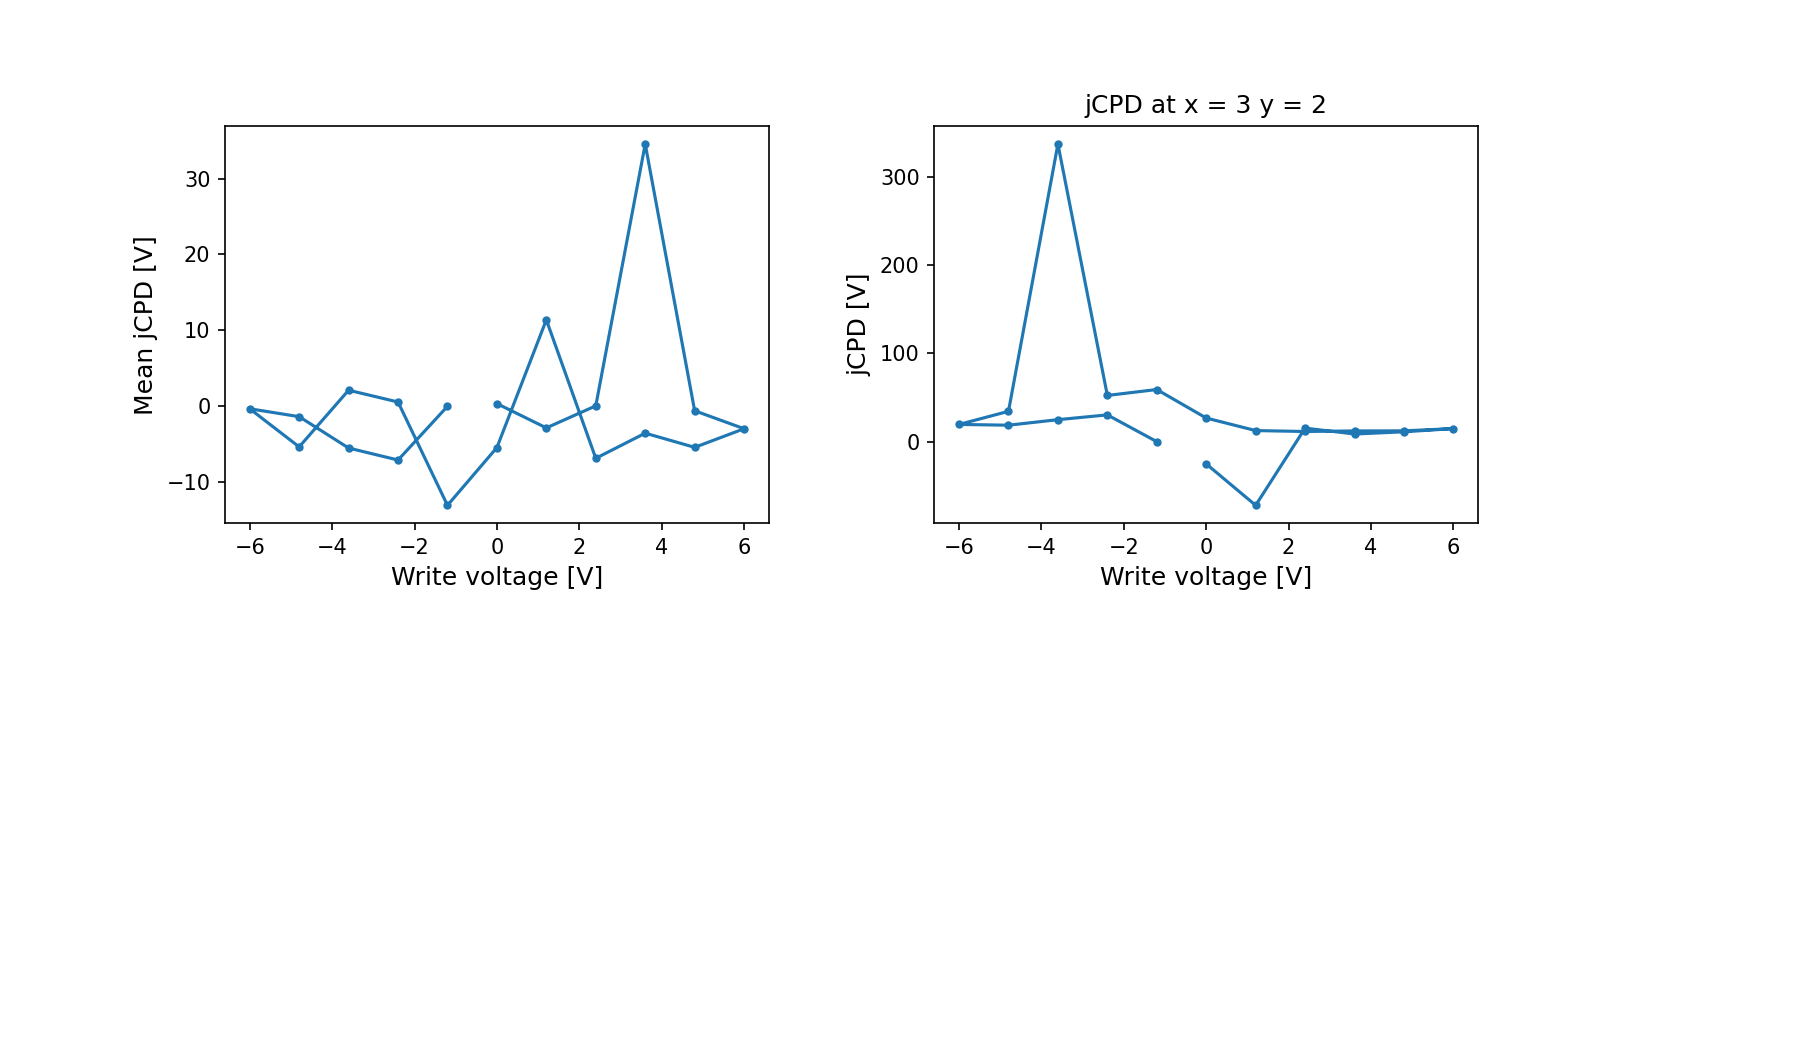

jCPD averaged over all pixels and write voltage steps = -0.5591658004864636 +/- 13.630228163902892 V


In [27]:
# specify x select and y select

x_select = 3
y_select = 2

x_range2 = [0, num_col-1]
y_range2 = [0, num_row-1]
# x_range2[0] = 0
# x_range2[1] = num_col-1
# y_range2[0] = 0
# y_range2[1] = num_row-1

jCPD_mean1 = np.nanmean(jCPD_mat[y_range2[0]:y_range2[1], x_range2[0]:x_range2[1],:],axis = 0)
jCPD_std1 = np.nanstd(jCPD_mat[y_range2[0]:y_range2[1], x_range2[0]:x_range2[1],:],axis = 0)
jCPD_mean_w = np.nanmean(jCPD_mean1,axis = 0)
jCPD_std_w = np.nanstd(jCPD_mean1,axis = 0)



#jCPD_mean_w[2] = np.nan


jCPD_mean_all = np.nanmean(jCPD_mean_w,axis = 0)
jCPD_std_all = np.nanstd(jCPD_std_w,axis = 0)


fig3 = plt.figure(figsize=(12,7))  
fig3.set_facecolor('white')
ax_jCPD_mean = plt.subplot2grid((10, 10), (0, 0), colspan=4, rowspan=5)
ax_jCPD_xy = plt.subplot2grid((10, 10), (0, 5), colspan=4, rowspan=5)

plt.title('Mean jCPD vs write voltage', fontsize = 12)
# ax_jCPD_mean.errorbar(bias_vec_w, jCPD_mean_w, yerr = jCPD_std_w, fmt = '.-')
ax_jCPD_mean.plot(bias_vec_w, jCPD_mean_w, '.-')
ax_jCPD_mean.set_xlabel('Write voltage [V]', fontsize = 12)
ax_jCPD_mean.set_ylabel('Mean jCPD [V]', fontsize = 12)
# ax_jCPD_mean.set_ylim([-10,10])

ax_jCPD_xy.plot(bias_vec_w, jCPD_mat[y_select,x_select, : ], '.-')
ax_jCPD_xy.set_xlabel('Write voltage [V]', fontsize = 12)
ax_jCPD_xy.set_ylabel('jCPD [V]', fontsize = 12)
# ax_jCPD_xy.set_ylim([-10,15])
plt.title('jCPD at x = '+str(x_select)+' y = '+str(y_select))

print('jCPD averaged over all pixels and write voltage steps = '+ str(jCPD_mean_all)+' +/- '+str(jCPD_std_all)+' V')

## PCA analysis

### Singular value decomposition performed on raw data:

In [29]:
# Do SVD on raw data
print(h5_main.shape)
do_svd = px.svd_utils.SVD(h5_main, num_components=40)
SVD_data = do_svd.compute()


(100, 54560)


AttributeError: module 'pyUSID' has no attribute 'svd_utils'

### SVD on jCPD, slope, y-intercept data and response at 0 V read voltage:

In [ ]:
# Do SVD on jCPD, slope and y-intercept data

from sklearn.utils.extmath import randomized_svd

num_components = 20;

# # #Filter outliers from jCPD matrix, (-> improve code)
# # for r in range(1, num_row):
# #     for c in range(1, num_col):
# #         for s in range(1, num_write_steps):
# #             if jCPD_mat[r-1, c-1, s-1] > 5 or jCPD_mat[r-1, c-1, s-1] < -5:
# #                 jCPD_mat[r-1, c-1, s-1] = np.nan
# # #                 jCPD_mat[r-1, c-1, s-1] = 0


x_delete = np.array([])
y_delete = np.array([])


index_delete = (num_col)*y_delete+x_delete


jCPD_mat_SVD = np.reshape(jCPD_mat,(num_row*num_col, num_write_steps))

nan_pos = np.squeeze((np.argwhere(np.isnan(jCPD_mat_SVD).any(axis=1))))
index_delete = np.insert(index_delete, index_delete.shape[0], nan_pos, axis = 0)

index_delete = -np.sort(-index_delete)


jCPD_mat_SVD_clean = jCPD_mat_SVD

for i in range(0,index_delete.shape[0]):
    jCPD_mat_SVD_clean = np.delete(jCPD_mat_SVD_clean, index_delete[i], axis = 0)

U_SVD_jCPD, S_SVD_jCPD, V_SVD_jCPD = randomized_svd(jCPD_mat_SVD_clean, n_components = num_components)


index_delete = np.sort(index_delete)

for i in range(0,index_delete.shape[0]):
    U_SVD_jCPD = np.insert(U_SVD_jCPD, index_delete[i], np.nan ,axis = 0)
    print(i,index_delete[i])
    
print(U_SVD_jCPD.shape)


slope_mat_SVD = np.reshape(fit_slope,(num_row*num_col, num_write_steps))
U_SVD_slope, S_SVD_slope, V_SVD_slope = randomized_svd(slope_mat_SVD, n_components = num_components)

yintercept_mat_SVD = np.reshape(fit_yintercept,(num_row*num_col, num_write_steps))
U_SVD_yintercept, S_SVD_yintercept, V_SVD_yintercept = randomized_svd(yintercept_mat_SVD, n_components = num_components)


# Do SVD on cKPFM signal at 0 V read voltage (= PFM)
dc_step_read = np.argwhere(np.isclose(bias_vec_r[0,:], 0)).squeeze()

resp_mat_0Vr = np.squeeze(Nd_mat[:,:,1,:,dc_step_read]['Amplitude [V]'] * 
                          np.cos(Nd_mat[:,:,1,:,dc_step_read]['Phase [rad]'])*1000)

resp_mat_0Vr = np.reshape(resp_mat_0Vr,(num_row*num_col, num_write_steps))
U_SVD_resp0Vr, S_SVD_resp0Vr, V_SVD_resp0Vr = randomized_svd(resp_mat_0Vr, n_components = num_components)


### Display SVD score maps and eigenvectors of jCPD data:

In [ ]:
# Visualize PCA of jCPD data

U_SVD_jCPD = np.reshape(U_SVD_jCPD,(num_row, num_col, num_components))

fig5 = plt.figure(figsize=(12,12))
fig5.clf()
fig5.set_facecolor('white')    

n_components = 20

for component in range(1, n_components+1):
    

    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.imshow(U_SVD_jCPD[:,:,component-1], cmap=px.plot_utils.cmap_jet_white_center(), 
                               origin='upper', interpolation='none');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    
    fig5.colorbar(image, ax = ax_SVD_plot)
    
fig5.suptitle('PCA scores of jCPD data', weight = 'bold', fontsize = 12, y=1)
fig5.tight_layout()



fig55 = plt.figure(figsize=(12,12))
fig55.clf()
fig55.set_facecolor('white')

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.plot(bias_vec_w, V_SVD_jCPD[component-1,:],'.-');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    ax_SVD_plot.set_xlabel('Write voltage [V]')


fig55.suptitle('PCA eigenvectors of jCPD data', weight = 'bold', fontsize = 12, y=1);

fig55.tight_layout()


def on_save_button4_clicked(b):
   
    fig5.savefig(output_file_path+'\PCA_jCPD_scores.png', format='png')
    fig5.savefig(output_file_path+'\PCA_jCPD_scores.eps', format='eps')
    fig5.savefig(output_file_path+'\PCA_jCPD_scores.tif', format='tif')
    fig55.savefig(output_file_path+'\PCA_jCPD_ev.png', format='png')
    fig55.savefig(output_file_path+'\PCA_jCPD_ev.eps', format='eps')
    fig55.savefig(output_file_path+'\PCA_jCPD_ev.tif', format='tif')

    
button4 = widgets.Button(description = 'Save figure')
display(button4)
button4.on_click(on_save_button4_clicked)




### Display SVD score maps and eigenvectors of slope data:

In [ ]:
# Visualize PCA of slope data
U_SVD_slope = np.reshape(U_SVD_slope,(num_row, num_col, num_components))

fig6 = plt.figure(figsize=(12,12))
fig6.clf()
fig6.set_facecolor('white')    

n_components = 20

for component in range(1, n_components+1):
    

    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.imshow(U_SVD_slope[:,:,component-1], cmap=px.plot_utils.cmap_jet_white_center(), 
                               origin='upper', interpolation='none');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    fig6.colorbar(image, ax = ax_SVD_plot)
    
fig6.tight_layout()
fig6.suptitle('PCA scores of slope data', weight = 'bold', fontsize = 12, y = 1);


fig66 = plt.figure(figsize=(12,12))
fig66.clf()
fig66.set_facecolor('white')

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.plot(bias_vec_w, V_SVD_slope[component-1,:],'.-');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    ax_SVD_plot.set_xlabel('Write voltage [V]')
fig66.tight_layout()

fig66.suptitle('PCA eigenvectors of slope data', weight = 'bold', fontsize = 12, y = 1);

def on_save_button5_clicked(b):
   
    fig6.savefig(output_file_path+'\PCA_slope_scores.png', format='png')
    fig6.savefig(output_file_path+'\PCA_slope_scores.eps', format='eps')
    fig6.savefig(output_file_path+'\PCA_slope_scores.tif', format='tif')
    fig66.savefig(output_file_path+'\PCA_slope_ev.png', format='png')
    fig66.savefig(output_file_path+'\PCA_slope_ev.eps', format='eps')
    fig66.savefig(output_file_path+'\PCA_slope_ev.tif', format='tif')

    
button5 = widgets.Button(description = 'Save figure')
display(button5)
button5.on_click(on_save_button5_clicked)

### Display SVD score maps and eigenvectors of y-intercept data:

In [ ]:
# Visualize PCA of y-intercept data
U_SVD_yintercept = np.reshape(U_SVD_yintercept,(num_row, num_col, num_components))

fig7 = plt.figure(figsize=(12,12))
fig7.clf()
fig7.set_facecolor('white')    

n_components = 20

for component in range(1, n_components+1):
    

    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.imshow(U_SVD_yintercept[:,:,component-1], cmap=px.plot_utils.cmap_jet_white_center(), 
                               origin='upper', interpolation='none');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    
    fig7.colorbar(image, ax = ax_SVD_plot)
    

fig7.tight_layout()

fig7.suptitle('PCA scores of y-intercept data', weight = 'bold', fontsize = 12, y = 1);

fig77 = plt.figure(figsize=(12,12))
fig77.clf()
fig77.set_facecolor('white')

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.plot(bias_vec_w, V_SVD_yintercept[component-1,:],'.-');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    ax_SVD_plot.set_xlabel('Write voltage [V]')
fig77.tight_layout()

fig77.suptitle('PCA eigenvectors of y-intercept data', weight = 'bold', fontsize = 12, y = 1);

def on_save_button6_clicked(b):
   
    fig7.savefig(output_file_path+'\PCA_yintercept_scores.png', format='png')
    fig7.savefig(output_file_path+'\PCA_yintercept_scores.eps', format='eps')
    fig7.savefig(output_file_path+'\PCA_yintercept_scores.tif', format='tif')
    fig77.savefig(output_file_path+'\PCA_yintercept_ev.png', format='png')
    fig77.savefig(output_file_path+'\PCA_yintercept_ev.eps', format='eps')
    fig77.savefig(output_file_path+'\PCA_yintercept_ev.tif', format='tif')

    
button6 = widgets.Button(description = 'Save figure')
display(button6)
button6.on_click(on_save_button6_clicked)

### Display SVD score maps and eigenvectors of response at 0 V read voltage:

In [ ]:
# Visualize PCA of response at 0 V read voltage
U_SVD_resp0Vr = np.reshape(U_SVD_resp0Vr,(num_row, num_col, num_components))

fig8 = plt.figure(figsize=(12,12))
fig8.clf()
fig8.set_facecolor('white')    

n_components = 20


for component in range(1, n_components+1):
    

    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.imshow(U_SVD_resp0Vr[:,:,component-1], cmap=px.plot_utils.cmap_jet_white_center(), 
                               origin='upper', interpolation='none');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    fig8.colorbar(image, ax = ax_SVD_plot)
    

fig8.tight_layout()

fig8.suptitle('PCA scores of response at V$_{read}$ = 0 V', weight = 'bold', fontsize = 12, y = 1);

fig88 = plt.figure(figsize=(12,12))
fig88.clf()
fig88.set_facecolor('white')

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(5, 4, component)
    image = ax_SVD_plot.plot(bias_vec_w, V_SVD_resp0Vr[component-1,:],'.-');
    ax_SVD_plot.set_xlabel('Write voltage [V]')
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
fig88.tight_layout()

fig88.suptitle('PCA eigenvectors of response at V$_{read}$ = 0 V', weight = 'bold', fontsize = 12, y = 1);

def on_save_button7_clicked(b):
   
    fig8.savefig(output_file_path+'\PCA_resp0V_scores.png', format='png')
    fig8.savefig(output_file_path+'\PCA_resp0V_scores.eps', format='eps')
    fig8.savefig(output_file_path+'\PCA_resp0V_scores.tif', format='tif')
    fig88.savefig(output_file_path+'\PCA_resp0V_ev.png', format='png')
    fig88.savefig(output_file_path+'\PCA_resp0V_ev.eps', format='eps')
    fig88.savefig(output_file_path+'\PCA_resp0V_ev.tif', format='tif')

    
button7 = widgets.Button(description = 'Save figure')
display(button7)
button7.on_click(on_save_button7_clicked)

### Display SVD score maps and eigenvectors of raw data:

In [ ]:
# Visualize PCA of raw data
S_mat = SVD_data['S'][:]
U_mat = SVD_data['U'][:]
V_mat = SVD_data['V'][:]

n_components = min(40, S_mat.size)

U_mat = np.reshape(U_mat,(num_row, num_col, n_components))

fig4 = plt.figure(figsize=(12,20))
fig4.clf()
fig4.set_facecolor('white')    

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(10, 4, component)
    
    image = ax_SVD_plot.imshow(U_mat[:,:,component-1], 
                            cmap=px.plot_utils.cmap_jet_white_center(), 
                            origin='upper', interpolation='none');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
    fig4.colorbar(image, ax = ax_SVD_plot)
    
fig4.tight_layout()


fig4.suptitle('PCA scores of raw data', weight = 'bold', fontsize = 12, y = 1);


fig44 = plt.figure(figsize=(12,20))
fig44.clf()
fig44.set_facecolor('white')

for component in range(1, n_components+1):
    ax_SVD_plot = plt.subplot(10, 4, component)
    image = ax_SVD_plot.plot(V_mat[component-1,:],'.-');
    ax_SVD_plot.set_title('#'+str(component), fontsize = 10)
fig44.tight_layout()

fig44.suptitle('PCA eigenvectors of of raw data', weight = 'bold', fontsize = 12, y = 1);

def on_save_button8_clicked(b):
   
    fig4.savefig(output_file_path+'\PCA_rawdata_scores.png', format='png')
    fig4.savefig(output_file_path+'\PCA_rawdata_scores.eps', format='eps')
    fig4.savefig(output_file_path+'\PCA_rawdata_scores.tif', format='tif')
    fig44.savefig(output_file_path+'\PCA_rawdata_ev.png', format='png')
    fig44.savefig(output_file_path+'\PCA_rawdata_ev.eps', format='eps')
    fig44.savefig(output_file_path+'\PCA_rawdata_ev.tif', format='tif')

    
button8 = widgets.Button(description = 'Save figure')
display(button8)
button8.on_click(on_save_button8_clicked)

# BEPS/ FORC viewer

In [ ]:
global count
count = 0
cycle = 0
row = 0
col = 0
dc_step_write = 0
step_chan = b'read_bias'

guess_3d_data, success = px.hdf_utils.reshape_to_Ndims(h5_sho_fit)
h5_sho_spec_inds = px.hdf_utils.getAuxData(h5_sho_fit, auxDataName='Spectroscopic_Indices')[0]
h5_sho_spec_vals = px.hdf_utils.getAuxData(h5_sho_fit, auxDataName='Spectroscopic_Values')[0]

spec_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_sho_spec_inds, h5_spec=h5_sho_spec_inds)

spec_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_sho_spec_inds, h5_spec=h5_sho_spec_inds)
# sho_spec_sort = get_sort_order(h5_sho_spec_inds)
sho_spec_dims = np.array(spec_nd.shape[1:])
sho_spec_labels = h5_sho_spec_inds.attrs['labels']

h5_pos_inds = px.hdf_utils.getAuxData(h5_sho_fit, auxDataName='Position_Indices')[-1];
pos_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_pos_inds, h5_pos=h5_pos_inds)
pos_dims = list(pos_nd.shape[:h5_pos_inds.shape[1]])
pos_labels = h5_pos_inds.attrs['labels']

# reshape to X, Y, step, all others
spec_step_dim_ind = np.where(sho_spec_labels == step_chan)[0]
step_dim_ind = len(pos_dims) + spec_step_dim_ind

# move the step dimension to be the first after all position dimensions
rest_sho_dim_order = list(range(len(pos_dims), len(guess_3d_data.shape)))
rest_sho_dim_order.remove(step_dim_ind)
new_order = list(range(len(pos_dims))) + step_dim_ind.tolist() + rest_sho_dim_order

# Transpose the 3D dataset to this shape:
sho_guess_Nd_1 = np.transpose(guess_3d_data, new_order)

# Now move the step dimension to the front for the spec labels as well
new_spec_order = list(range(len(sho_spec_labels)))
new_spec_order.remove(spec_step_dim_ind)
new_spec_order = spec_step_dim_ind.tolist() + new_spec_order

# new_spec_labels = sho_spec_labels[new_spec_order]
new_spec_dims = np.array(sho_spec_dims)[new_spec_order]

# Now collapse all additional dimensions
final_guess_shape = pos_dims + [new_spec_dims[0]] + [-1]
sho_dset_collapsed = np.reshape(sho_guess_Nd_1, final_guess_shape)

# Get the bias matrix:
bias_mat, _ = px.hdf_utils.reshape_to_Ndims(h5_sho_spec_vals, h5_spec=h5_sho_spec_inds)
bias_mat = np.transpose(bias_mat[spec_step_dim_ind].squeeze(), new_spec_order).reshape(sho_dset_collapsed.
                                                                             shape[len(pos_dims):])
bias_mat = bias_mat*high_voltage_amplf

num_read_steps = sho_dset_collapsed.shape[1]
num_write_steps = sho_dset_collapsed.shape[2]
num_row = sho_dset_collapsed.shape[1]
num_col = sho_dset_collapsed.shape[0]

print(sho_dset_collapsed.shape)
print('bias mat shape', bias_mat.shape)

num_loops = bias_mat.shape[1]
num_loops_h = int(num_loops/2)
# plt.figure()
# plt.plot(bias_mat[:,:]);



# print(sho_dset_collapsed.attrs)
# print(getattr(obj))

amp_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Amplitude [V]']*1000
phase_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Phase [rad]']
frequency_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Frequency [Hz]']/1000
Q_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Quality Factor']

mixed_map = amp_map*np.cos(phase_map)
mixed_mat_h = sho_dset_collapsed[:, :, :, :]['Amplitude [V]'] * np.cos(sho_dset_collapsed[:, :, :, :]['Phase [rad]'])*1000

print('mixed shape = ', mixed_mat_h.shape)

def make_figure_beps_forc(amp_map, phase_map, mixed_map, Q_map, frequency_map, mixed_mat_h, col, row, cycle, dc_step_write):
    global fig_bf
    fig_bf = plt.figure(figsize=(12,6))
    fig_bf.clf()
    fig_bf.set_facecolor('white')  
    
    
    
    ax_amp = plt.subplot(2, 3, 1)
    img_a = ax_amp.imshow(amp_map, cmap=px.plot_utils.cmap_jet_white_center(), 
                          origin='upper', interpolation='none');
    ax_amp.set_title('Amplitude [a.u.]', fontsize = 10)
    fig_bf.colorbar(img_a, ax = ax_amp)

    ax_phase = plt.subplot(2, 3, 2)
    img_p = ax_phase.imshow(phase_map, cmap=px.plot_utils.cmap_jet_white_center(), 
                          origin='upper', interpolation='none', clim = [-3.5, 3.5]);
    ax_phase.set_title('Phase [rad]', fontsize = 10)
    fig_bf.colorbar(img_p, ax = ax_phase)

    ax_m = plt.subplot(2, 3, 3)
    img_m = ax_m.imshow(mixed_map, cmap=px.plot_utils.cmap_jet_white_center(), 
                          origin='upper', interpolation='none');
    ax_m.set_title('Real component [a.u.]', fontsize = 10)
    fig_bf.colorbar(img_m, ax = ax_m)

    ax_q = plt.subplot(2, 3, 4)
    img_q = ax_q.imshow(Q_map, cmap=px.plot_utils.cmap_jet_white_center(), 
                          origin='upper', interpolation='none');
    ax_q.set_title('Quality factor', fontsize = 10)
    fig_bf.colorbar(img_q, ax = ax_q)   

    ax_f = plt.subplot(2, 3, 5)
    img_f = ax_f.imshow(frequency_map, cmap=px.plot_utils.cmap_jet_white_center(), 
                          origin='upper', interpolation='none');
    ax_f.set_title('Resonance frequency [kHz]', fontsize = 10)
    fig_bf.colorbar(img_f, ax = ax_f) 

    ax_h = plt.subplot(2, 3, 6)
    ax_h.plot(bias_mat[:,0:num_loops//2], mixed_mat_h[row, col, :, 0:num_loops//2],'-.', marker ='*')
    ax_h.plot(bias_mat[:,num_loops_h:num_loops], mixed_mat_h[row, col, :, num_loops_h:num_loops],'.-')
    ax_h.set_ylabel('Response [a.u.]')
    ax_h.set_xlabel('Write voltage [V]')
    ax_h.set_title('x = '+str(col)+' y = '+str(row), fontsize = 10)
    
    
    fig_bf.suptitle('Step# = '+str(dc_step_write)+', cycle# = '+str(cycle)
                    +', V$_{write}$ = '+str(bias_mat[dc_step_write, 0]) +' V'
                   , fontsize = 12);
    

    fig_bf.tight_layout()
    
    plt.subplots_adjust(top = 0.9)

make_figure_beps_forc(amp_map, phase_map, mixed_map, Q_map, frequency_map, mixed_mat_h, col, row, cycle, dc_step_write)
    
def update_beps_forc_plot(dc_step_write, cycle, col, row):
       
    amp_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Amplitude [V]']*1000
    phase_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Phase [rad]']
    frequency_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Frequency [Hz]']/1000
    Q_map = sho_dset_collapsed[:, :, dc_step_write, cycle]['Quality Factor']
    mixed_map = amp_map*np.cos(phase_map)
    mixed_mat_h = sho_dset_collapsed[:, :, :, :]['Amplitude [V]'] * np.cos(sho_dset_collapsed[:, :, :, :]['Phase [rad]'])*1000

    make_figure_beps_forc(amp_map, phase_map, mixed_map, Q_map, frequency_map, mixed_mat_h, col, row, cycle, dc_step_write)

num_loops_h =num_loops//2-1

dc_step_write_slider_bf = widgets.IntSlider(min = 0, max = num_write_steps-1, step = 1,value = 0,
                                        description = 'Write step',continuous_update = False)
cycle_slider = widgets.IntSlider(min = 2, max = num_loops-1, step = 1,value = 2,
                                          description = 'Cycle', continuous_update = False)
x_slider_bf  = widgets.IntSlider(min = 0, max = num_col-1,step = 1,value = 0,
                             description='x',continuous_update = False)
y_slider_bf  = widgets.IntSlider(min = 0,max = num_row-1,step = 1,value = 0, description = 'y',continuous_update = False)

widgets.interact(update_beps_forc_plot, dc_step_write = dc_step_write_slider_bf, cycle = cycle_slider, 
                 col = x_slider_bf, row = y_slider_bf, **slider_dict); 


def on_save_button9_clicked(b):
    global count
    
    fig_bf.savefig(output_file_path+'\SHO_parms'+str(count)+'.png', format='png')
    fig_bf.savefig(output_file_path+'\SHO_parms'+str(count)+'.eps', format='eps')
    fig_bf.savefig(output_file_path+'\SHO_parms'+str(count)+'.tif', format='tif')
    count+=1
    
button9 = widgets.Button(description = 'Save figure')
display(button9)
button9.on_click(on_save_button9_clicked)

In [ ]:
amp_data = sho_dset_collapsed[:, :, :, :]['Amplitude [V]']*1000
phase_data = sho_dset_collapsed[:, :, :, :]['Phase [rad]']

amp_mean1 = np.nanmean(amp_data, axis = 0)
amp_mean = np.nanmean(amp_mean1, axis = 0)

phase_mean1 = np.nanmean(phase_data, axis = 0)
phase_mean = np.nanmean(phase_mean1, axis = 0)

mixed_mat_mean1 = np.nanmean(mixed_mat_h, axis = 0)
mixed_mat_mean = np.nanmean(mixed_mat_mean1, axis = 0)

fig_loops = plt.figure(figsize=(16,4))
fig_loops.clf()
fig_loops.set_facecolor('white')  

ax_mixed = plt.subplot(1, 3, 1)
img_a = ax_mixed.plot(bias_mat[:, 2:4], mixed_mat_mean[:, 2:4],'.-');
ax_mixed.set_xlabel('DC voltage [V]', fontsize = 12)
ax_mixed.set_ylabel('Mixed response [a.u.]', fontsize = 12)

ax_phase = plt.subplot(1, 3, 2)
img_c = ax_phase.plot(bias_mat[:,2:4], phase_mean[:, 2:4],'.-');
ax_phase.set_xlabel('DC voltage [V]', fontsize = 12)
ax_phase.set_ylabel('Phase [rad]', fontsize = 12)

ax_amp = plt.subplot(1, 3, 3)
img_b = ax_amp.plot(bias_mat[:,2:4], amp_mean[:,2:4],'.-');
ax_amp.set_xlabel('DC voltage [V]', fontsize = 12)
ax_amp.set_ylabel('Amplitude [a.u.]', fontsize = 12)

def on_save_button10_clicked(b):
    fig_loops.savefig(output_file_path+'\Loops.png', format='png')
    fig_loops.savefig(output_file_path+'\Loops.eps', format='eps')
    fig_loops.savefig(output_file_path+'\Loops.tif', format='tif')
    
    
button10 = widgets.Button(description = 'Save figure')
display(button10)
button10.on_click(on_save_button10_clicked)


In [ ]:
# PCA on real component

from sklearn.utils.extmath import randomized_svd


mixed_mat_h[:, :, :, num_loops_h:num_loops]

# resp_mat_0Vr = np.reshape(resp_mat_0Vr,(num_row*num_col, num_write_steps))
# U_SVD_resp0Vr, S_SVD_resp0Vr, V_SVD_resp0Vr = randomized_svd(resp_mat_0Vr, n_components = num_components)

In [ ]:
from matplotlib.widgets import Cursor
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

x, y = 4*(np.random.rand(2, 100) - .5)
ax.plot(x, y, 'o')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# set useblit = True on gtkagg for enhanced performance
cursor = Cursor(ax, useblit=True, color='red', linewidth=2)

plt.show()

## Visualize the SHO results of BEline, BEPS and FORC data
Here, we visualize the parameters for the SHO fits. BE-line (3D) data is visualized via simple spatial maps of the SHO parameters while more complex BEPS datasets (4+ dimensions) can be visualized using a simple interactive visualizer below. 

You can choose to visualize the guesses for SHO function or the final fit values from the first line of the cell below.

Use the sliders below to inspect the BE response at any given location. 

In [ ]:
use_sho_guess = False
use_static_viz_func = False

if use_sho_guess:
    sho_dset = h5_sho_guess
else:
    sho_dset = h5_sho_fit

if hdf.file.attrs['data_type'] == 'BELineData' or len(pos_dims) != 2:
    use_static_viz_func = True
    step_chan = None
else:
    if h5_main.parent.parent.attrs['VS_mode'] not in ['AC modulation mode with time reversal', 
                                                      'DC modulation mode']:
        use_static_viz_func = True
    else:
        if h5_main.parent.parent.attrs['VS_mode'] == 'DC modulation mode':
            step_chan = 'DC_Offset'
        else:
            step_chan = 'AC_Amplitude'
if not use_static_viz_func:
    try:
        # use interactive visualization
        px.be_viz_utils.jupyter_visualize_beps_sho(sho_dset, step_chan)
    except:
        print('There was a problem with the interactive visualizer')
        use_static_viz_func = True
if use_static_viz_func:
    # show plots of SHO results vs. applied bias
    px.be_viz_utils.visualize_sho_results(sho_dset, show_plots=True, 
                                        save_plots=False)

In [ ]:
h5_sho_dset = sho_dset
resp_func = None
guess_3d_data, success = px.io.hdf_utils.reshape_to_Ndims(h5_sho_dset)

h5_sho_spec_inds = px.io.hdf_utils.getAuxData(h5_sho_dset, 'Spectroscopic_Indices')[0]
h5_sho_spec_vals = px.io.hdf_utils.getAuxData(h5_sho_dset, 'Spectroscopic_Values')[0]
spec_nd, _ = px.io.hdf_utils.reshape_to_Ndims(h5_sho_spec_inds, h5_spec=h5_sho_spec_inds)
# sho_spec_sort = get_sort_order(h5_sho_spec_inds)
sho_spec_dims = np.array(spec_nd.shape[1:])
sho_spec_labels = h5_sho_spec_inds.attrs['labels']

h5_pos_inds = px.io.hdf_utils.getAuxData(h5_sho_dset, auxDataName='Position_Indices')[-1]
pos_nd, _ = px.io.hdf_utils.reshape_to_Ndims(h5_pos_inds, h5_pos=h5_pos_inds)
print(pos_nd.shape)
pos_dims = list(pos_nd.shape[:h5_pos_inds.shape[1]])
print(pos_dims)
pos_labels = h5_pos_inds.attrs['labels']
print(pos_labels)

# reshape to X, Y, step, all others
spec_step_dim_ind = np.argwhere(sho_spec_labels == step_chan)[0][0]
step_dim_ind = len(pos_dims) + spec_step_dim_ind

# move the step dimension to be the first after all position dimensions
rest_sho_dim_order = list(range(len(pos_dims), len(guess_3d_data.shape)))
rest_sho_dim_order.remove(step_dim_ind)
new_order = list(range(len(pos_dims))) + [step_dim_ind] + rest_sho_dim_order

# Transpose the 3D dataset to this shape:
sho_guess_Nd_1 = np.transpose(guess_3d_data, new_order)

# Now move the step dimension to the front for the spec labels as well
new_spec_order = list(range(len(sho_spec_labels)))
new_spec_order.remove(spec_step_dim_ind)
new_spec_order = [spec_step_dim_ind] + new_spec_order

# new_spec_labels = sho_spec_labels[new_spec_order]
new_spec_dims = np.array(sho_spec_dims)[new_spec_order]

# Now collapse all additional dimensions
final_guess_shape = pos_dims + [new_spec_dims[0]] + [-1]
sho_dset_collapsed = np.reshape(sho_guess_Nd_1, final_guess_shape)

# Get the bias matrix:
bias_mat, _ = px.io.hdf_utils.reshape_to_Ndims(h5_sho_spec_vals, h5_spec=h5_sho_spec_inds)
bias_mat = np.transpose(bias_mat[spec_step_dim_ind], new_spec_order).reshape(sho_dset_collapsed.shape[len(pos_dims):])

# This is just the visualizer:
sho_quantity = 'Amplitude [V]'
step_ind = 0
row_ind = 1
col_ind = 1

def dc_spectroscopy_func(resp_vec):
    return resp_vec['Amplitude [V]'] * np.cos(resp_vec['Phase [rad]']) * 1E+3

def ac_spectroscopy_func(resp_vec):
    return resp_vec['Amplitude [V]']

if resp_func is None:
    if step_chan == 'DC_Offset':
        resp_func = dc_spectroscopy_func
        resp_label = 'A cos($\phi$) (a. u.)'
    else:
        resp_func = ac_spectroscopy_func
        resp_label = 'Amplitude (a. u.)'

spatial_map = sho_dset_collapsed[:, :, step_ind, 0][sho_quantity]
resp_vec = sho_dset_collapsed[row_ind, col_ind, :, :]
resp_vec = resp_func(resp_vec)

## Fit loops to a function
This is applicable only to DC voltage spectroscopy datasets from BEPS. The PFM hysteresis loops in this dataset will be projected to maximize the loop area and then fitted to a function.

Note: This computation generally takes a while for reasonably sized datasets.

In [ ]:
# Do the Loop Fitting on the SHO Fit dataset
loop_success = False
h5_loop_group = px.hdf_utils.findH5group(h5_sho_fit, 'Loop_Fit')
if len(h5_loop_group) == 0:
    try:
        loop_fitter = px.BELoopModel(h5_sho_fit, variables=['read_bias'], parallel=True)
        print('No loop fits found. Fitting now....')
        h5_loop_guess = loop_fitter.do_guess(processors=max_cores, max_mem=max_mem)
        h5_loop_fit = loop_fitter.do_fit(processors=max_cores, max_mem=max_mem)
        loop_success = True
    except ValueError:
        print('Loop fitting is applicable only to DC spectroscopy datasets!')
        raise
else:
    loop_success = True
    print('Taking previously computed loop fits')
    h5_loop_guess = h5_loop_group[-1]['Guess']
    h5_loop_fit = h5_loop_group[-1]['Fit']

## Prepare datasets for visualization

In [ ]:
# Prepare some variables for plotting loops fits and guesses
# Plot the Loop Guess and Fit Results
if loop_success:
    h5_projected_loops = h5_loop_guess.parent['Projected_Loops']
    h5_proj_spec_inds = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Indices')[-1]
    h5_proj_spec_vals = px.hdf_utils.getAuxData(h5_projected_loops, 
                                                auxDataName='Spectroscopic_Values')[-1]

    # reshape the vdc_vec into DC_step by Loop
    sort_order = px.hdf_utils.get_sort_order(h5_proj_spec_inds)
    dims = px.hdf_utils.get_dimensionality(h5_proj_spec_inds[()], 
                                           sort_order[::-1])
    vdc_vec = np.reshape(h5_proj_spec_vals[h5_proj_spec_vals.attrs['read_bias']], dims).T

    #Also reshape the projected loops to Positions-DC_Step-Loop
    # Also reshape the projected loops to Positions-DC_Step-Loop
    proj_nd, _ = px.hdf_utils.reshape_to_Ndims(h5_projected_loops)
    proj_3d = np.reshape(proj_nd, [h5_projected_loops.shape[0], 
                                   proj_nd.shape[2], -1])

## Visualize Loop fits

In [ ]:
use_static_plots = False
if loop_success:
    if not use_static_plots:
        try:
            px.be_viz_utils.jupyter_visualize_beps_loops(h5_projected_loops, h5_loop_guess, h5_loop_fit)
        except:
            print('There was a problem with the interactive visualizer')
            use_static_plots = True
    if use_static_plots:
        for iloop in range(h5_loop_guess.shape[1]):
            fig, ax = px.be_viz_utils.plot_loop_guess_fit(vdc_vec[:, iloop], proj_3d[:, :, iloop], 
                                          h5_loop_guess[:, iloop], h5_loop_fit[:, iloop],
                                          title='Loop {} - All Positions'.format(iloop))

## Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [ ]:
hdf.close()